In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50

2025-08-24 16:44:02.603285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756053842.962665      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756053843.068463      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [3]:

IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 50

In [4]:
## Data Augmentation 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   validation_split=0.2)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

#
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         subset='validation',
                                                         shuffle=False)


test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:

class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

samples_per_class = 3  

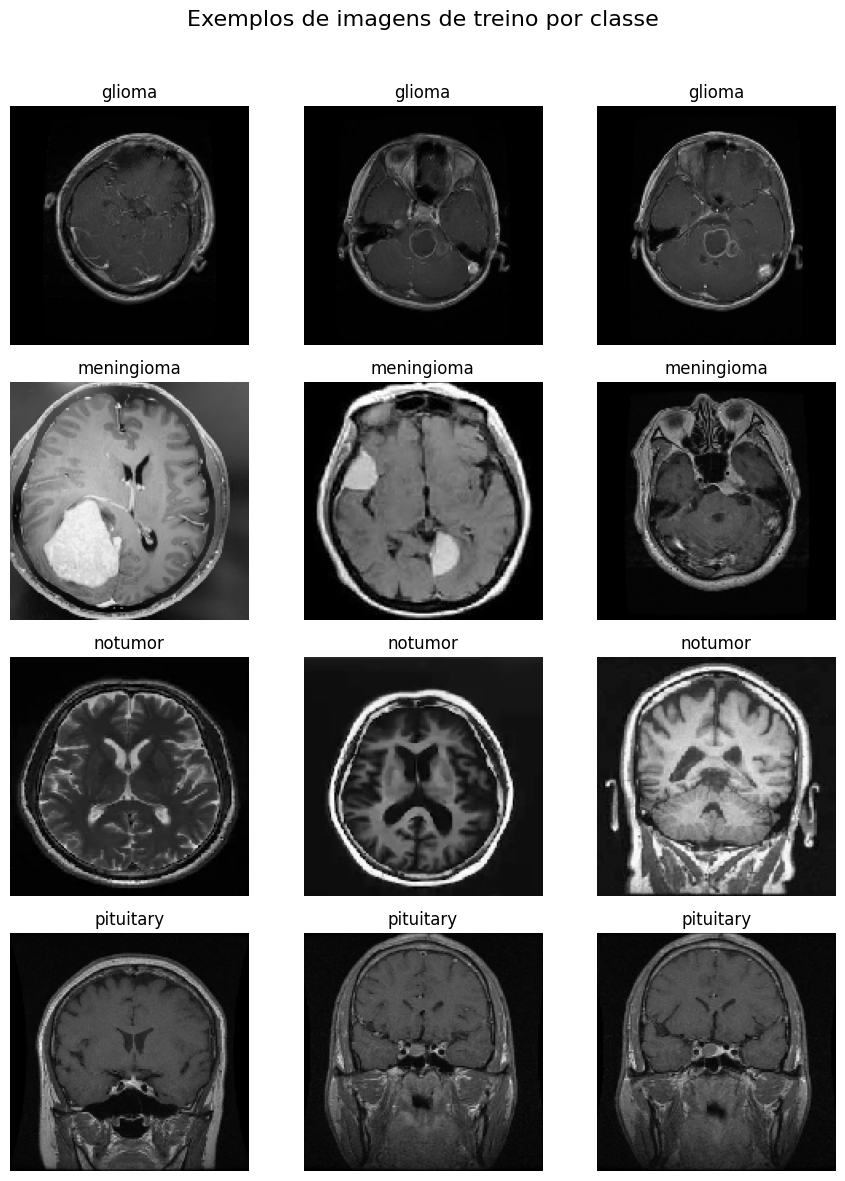

In [6]:

plt.figure(figsize=(samples_per_class * 3, num_classes * 3))
for idx, class_label in enumerate(class_labels):
    
    class_index = train_generator.class_indices[class_label]
    
    filepaths = train_generator.filepaths
    classes = train_generator.classes
    
    indices = [i for i, c in enumerate(classes) if c == class_index]
    
    selected = indices[:samples_per_class]

    for j, i in enumerate(selected):
        img_path = filepaths[i]
        img = load_img(img_path, target_size=IMG_SIZE)
        img_arr = img_to_array(img) / 255.0
        ax = plt.subplot(num_classes, samples_per_class, idx * samples_per_class + j + 1)
        ax.imshow(img_arr.astype('float32'))
        ax.set_title(f'{class_label}')
        ax.axis('off')
        
plt.suptitle('Exemplos de imagens de treino por classe', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


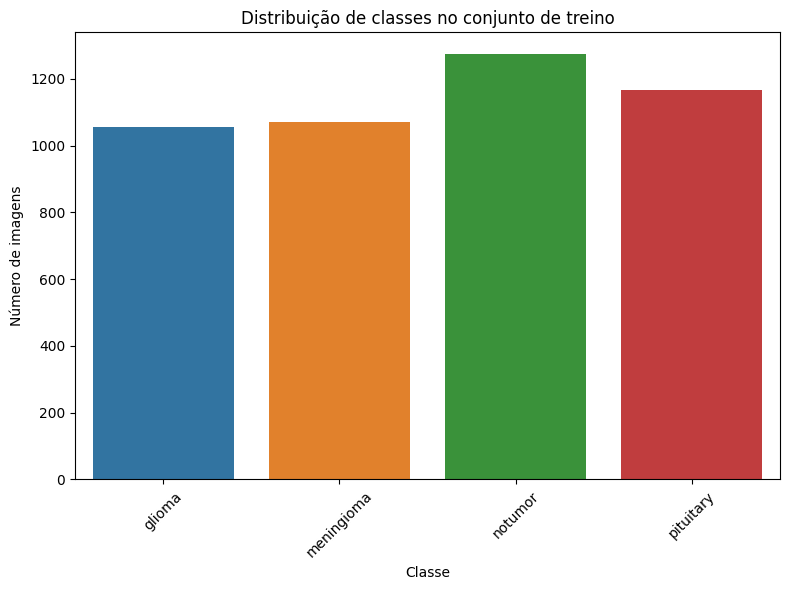

In [7]:
class_labels = list(train_generator.class_indices.keys())
train_classes = train_generator.classes
plt.figure(figsize=(8, 6))

sns.countplot(x=[class_labels[c] for c in train_classes])
plt.title('Distribuição de classes no conjunto de treino')
plt.xlabel('Classe')
plt.ylabel('Número de imagens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = {i: class_weights_vals[i] for i in range(len(class_weights_vals))}
print('Class weights:', class_weights_dict)


Class weights: {0: 1.0811258278145695, 1: 1.0659981343283582, 2: 0.8955721003134797, 3: 0.9800600343053173}


In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Input

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756053865.294333      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756053865.295065      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,700,036 (21.74 MB)

 Trainable params: 5,699,076 (21.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
%%time

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1756053873.602064     119 service.cc:148] XLA service 0x7af46c005570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756053873.604450     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756053873.604475     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756053874.219526     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/143 ━━━━━━━━━━━━━━━━━━━━ 29:32 12s/step - accuracy: 0.2188 - loss: 2.9587

I0000 00:00:1756053880.294459     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - accuracy: 0.4977 - loss: 3.8225 - val_accuracy: 0.2550 - val_loss: 3.5671
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.6151 - loss: 0.9268 - val_accuracy: 0.2577 - val_loss: 5.9497
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.6675 - loss: 0.8120 - val_accuracy: 0.4654 - val_loss: 1.5058
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - accuracy: 0.6904 - loss: 0.7609 - val_accuracy: 0.5723 - val_loss: 1.5527
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 279ms/step - accuracy: 0.7311 - loss: 0.6921 - val_accuracy: 0.6740 - val_loss: 1.0671
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.7533 - loss: 0.6534 - val_accuracy: 0.6538 - val_loss: 1.1418
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - accuracy: 0.7867 - loss: 0.5706 - val_accuracy: 0.6766 - val_loss: 1.0656
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - accuracy: 0.7860 - loss: 0.5779 - val

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
sns.lineplot(ax=axs[0], x=range(1, len(history.history['accuracy'])+1), y=history.history['accuracy'], label='Training', color='blue')
sns.lineplot(ax=axs[0], x=range(1, len(history.history['val_accuracy'])+1), y=history.history['val_accuracy'], label='Validation', color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Loss
sns.lineplot(ax=axs[1], x=range(1, len(history.history['loss'])+1), y=history.history['loss'], label='Training Loss', color='orange')
sns.lineplot(ax=axs[1], x=range(1, len(history.history['val_loss'])+1), y=history.history['val_loss'], label='Validation Loss', color='purple')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
plt.tight_layout()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
axes = axes.flatten()

total_test = len(test_generator.filenames)
for i, ax in enumerate(axes):
    if i >= total_test:
        break
    img_batch, label_batch = test_generator[i]
    img = img_batch[0]
    true_label = np.argmax(label_batch[0])
    pred_label = predicted_classes[i]
    ax.imshow(img)
    ax.set_title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Modelo 2 - VGG16 ResNet50

In [ ]:
# Diretórios
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
# Data Augmentation para treino, com validação split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)
# Apenas rescale para teste/validação
test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
# Visualização da distribuição de classes no conjunto de treino com countplot
class_labels = list(train_generator.class_indices.keys())
train_classes = train_generator.classes
plt.figure(figsize=(8, 6))
sns.countplot(x=[class_labels[c] for c in train_classes])
plt.title('Distribuição de classes no conjunto de treino')
plt.xlabel('Classe')
plt.ylabel('Número de imagens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Cálculo de class weights para balancear classes de treino (opcional)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = {i: class_weights_vals[i] for i in range(len(class_weights_vals))}
print('Class weights:', class_weights_dict)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Função para construir modelo de transferência
def build_model(base_name, input_shape, num_classes, freeze_layers=True):

    #
    if base_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Base model {base_name} not supported")
    if freeze_layers:
        for layer in base_model.layers:
            layer.trainable = False

    #
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    #
    outputs = Dense(num_classes, activation='softmax')(x)

    #
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time

# Treinamento e armazenamento de resultados
results = {}
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
num_classes = len(class_labels)

for base_name in ['VGG16', 'ResNet50']:
    print(f"\nTreinando modelo com base {base_name}...")

    #
    model = build_model(base_name, input_shape, num_classes, freeze_layers=True)

    #
    history = model.fit(train_generator,
                        epochs=EPOCHS,
                        validation_data=validation_generator)
    
    # Avaliação no conjunto de teste
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'{base_name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')
    
    # Predições no conjunto de teste
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    
    # Armazenar tudo em results
    results[base_name] = {'model': model,
                          'history': history,
                          'predictions': predictions,
                          'predicted_classes': predicted_classes,
                          'true_classes': true_classes}

In [ ]:
# 6. Plotagem de curvas de treino em subplots (accuracy e loss) com cores customizadas
# Exemplo para VGG16 (pode repetir ou parametrizar conforme necessidade)
history = results['VGG16']['history']  # ou outro modelo

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy: Training em azul, Validation em vermelho
sns.lineplot(ax=axs[0], x=range(1, len(history.history['accuracy'])+1), y=history.history['accuracy'], label='Training', color='blue')
sns.lineplot(ax=axs[0], x=range(1, len(history.history['val_accuracy'])+1), y=history.history['val_accuracy'], label='Validation', color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy - VGG16')
axs[0].legend()

# Loss: Training em orange, Validation em purple
sns.lineplot(ax=axs[1], x=range(1, len(history.history['loss'])+1), y=history.history['loss'], label='Training Loss', color='orange')
sns.lineplot(ax=axs[1], x=range(1, len(history.history['val_loss'])+1), y=history.history['val_loss'], label='Validation Loss', color='purple')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss - VGG16')
axs[1].legend()
plt.tight_layout()

plt.show()

In [ ]:
# Separar loops para diferentes visualizações e relatórios
# 1. Matrizes de Confusão
for base_name, res in results.items():
    cm = confusion_matrix(res['true_classes'], res['predicted_classes'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {base_name}')
    plt.show()

In [ ]:
# 2. Classification Report
for base_name, res in results.items():
    print(f'Classification report - {base_name}:')
    report = classification_report(res['true_classes'], res['predicted_classes'], target_names=class_labels)
    print(report)

In [ ]:
# 3. Curvas ROC
for base_name, res in results.items():
    y_true_bin = label_binarize(res['true_classes'], classes=list(range(num_classes)))
    y_score = res['predictions']
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {base_name}')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# 4. Previsões em Subplots (exemplos)
for base_name, res in results.items():
    print(f'Exemplos de previsões - {base_name}')
    num_rows, num_cols = 3, 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.flatten()
    total_test = len(test_generator.filenames)
    for i, ax in enumerate(axes):
        if i >= total_test:
            break
        # Usar load_img para recarregar a imagem para visualização
        img_path = test_generator.filepaths[i]
        img = load_img(img_path, target_size=IMG_SIZE)
        img_arr = img_to_array(img) / 255.0
        true_label = res['true_classes'][i]
        pred_label = res['predicted_classes'][i]
        ax.imshow(img_arr.astype('float32'))
        ax.set_title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}')
        ax.axis('off')
    plt.suptitle(f'Previsões no conjunto de teste - {base_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
# 5. Comparação de Val Accuracy entre arquiteturas
plt.figure(figsize=(8, 6))
for base_name, res in results.items():
    hist = res['history']
    sns.lineplot(x=range(1, len(hist.history['val_accuracy'])+1), y=hist.history['val_accuracy'], label=f'Val Acc - {base_name}')
plt.xlabel('Epoch'); plt.ylabel('Validation Accuracy'); plt.title('Comparação de Val Accuracy')
plt.legend(); plt.tight_layout(); plt.show()